# Demo - Probabilistic Fourier with AR model on coefficients

This file provides an demo of the probabilistic Fourier framework as outline in "Bayesian spectrum estimation of unevenly sampled data" - Qi et al.

$$ {\bf{s}}_t = {\bf{s}}_{t-1} + {\bf{w}}_t $$
$$ {\bf{y}}_t = C^\top {\bf{s}}_t + {\bf{v}}_t $$

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using FFTW
using LAR
using LAR.Node
using Distributions

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
;

## Settings

In [2]:
# data loading
sound_file = "../data/woman.wav"   # specify sound location
fs_desired = 8000                  # specify desired sampling frequency

# input buffer parameters
step_size = 30                      # specify step size of buffer
buffer_size = 30                    # specify size of buffer

# probabilistic fourier parameters 
var_observation = 1e-3               # specify observation noise var
freq_bins = 15
freq = collect(fs_desired/(2*(freq_bins+1)):fs_desired/(2*(freq_bins+1)):(fs_desired/2-fs_desired/(2*(freq_bins+1))))

# AR modelling
AR_order = 2
iterations = 5
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[1*fs_time+1:4*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)
x_time_clean = x_time
x_time = x_time_clean + rand(Distributions.Normal(0, sqrt(var_observation)), length(x_time_clean))

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQC+bOu90m43vtbknL3lVwW+rTffvGvZQ7zRDRc9LeioPZZWaz7LHn4+LFyaPsR5bj7MfEk+ERYrPm/OGTzr1QS9FbH1O4JSE76HETu+a9g5vq3qQL1oRGm9L2dhvQ6mWbvs3lE9CwVAvONymj0FhBa81Ztxva4pnb23MNm98kwMvr58tL28qga+i2KKvdBrab1JMb29ps7qPEHmBj6QgDo+6b44PjGniT70f4w+isSIPqZxMz4fF+O7tA3ou7FjkTxCpNm9X9FGvsK2O77ptZC9e06cvT6z4LwA/6y8GlN9PeXAKz0uIlA9GS+PvVYGe7zlB+68ccK3vdg75r2Wyy6+xeb2vUpa3r3RXfe9ZNaivb7Pkj3cPvw9mUxAPsHQbz5VKqo+q8eqPuyDXj4Mkz49brgEPUok/jx1a/a9G8Bdvh30bL6oig++DVHnvdAtvb0ii2y9DIy4PSjz3z1DvYU9e1qWvCrlST2KKAs8HUScPPE9vL0eCBa+82r1vVcX4L3IF8m9QOrGvaHOgTvhXto850QyPrR9ST5EzzU+2POJPo3Rfz597T0+QWzLPCY5ybyNbVO9VxblvfBtWb7YE0m+2dIFvvKYx73pq+m9+c5RvUvqEDwyOko9M1eEPZQyvzxP7Yk8WA1BvW71XDyOHhW+X0PIvWO3Yb0UncS8JtS0OyVZhD1GqhI+KCE7PvByZj43vYw+OzkePluGobtBuxE9NwLauyYPGL7wdC6+OYvHvX5pwr2FgT6+HFANvu+sE72dSeQ9qhMEPqMU2z3kgGQ8D7oEvThKeTwKuqY4EMFNvR9XSr3qRSG+ZkzJvS7Uz73DHbO9HGeNvUSm+Lz50xM9gjpAPUIZDD72euY9FjsvPjaRrT2Ak9Y9lrTcPRcmdj2Op0u8xqhsvdZKnrxgGbC91/T1vWTQk739ZJG9hEyqvW7pC76NaTU9V8vovCereLrUEZ69Iu1CvZQyiL2T4ZI7bZ8vvUBPhbu6HrU9l7LgPZa/Dz4aKko+gR9KPqzufj6BB4g9aYIUPGNhZbwQeca9hulyvksXcr4IvQO+k3zWvcJuLL7Gba+9LzN1Pc2swz2Q7649DEaiPa/zzz1vgdQ9AFHCPeXwwjuzZm+9svAEvQtneL1ZOYS9a3Alvny+1r2fWw+99EasvUYVib12b009Vm67PY8NijzfCZQ9d7l7O/DKgT36ejI9LNhKvKDzQj0F0dS8HiYMPX1svrza1ri8JGWbPKGv9DsBAeU8msYOvbC7vrzX2FC9OtpOvBhKObyPoEc6xoOMvBW4CTxp5ca85nbVOq/n1zyaZYE9VcNCPauToj1PlCk9t9ZrvUJJgj3/Bgg9IVUfPY+lKL2x1eU8w69kvW8zK711RMO8sqcmvdSG371p1Jq93BfhvH/Fvb16fi29GlSbvbiHizxOrCy9MdUvPVpSGj3pqjQ8tn18PNT107wgSgU9/khEPd6hozzCnHw9dXUBPV0CUDwgnLQ8VSTRvD/Zc71ay3K9upbAvFCgj73UYIG9xY0Gvt/dpr0NtwW9A++9vavcmb2iCaS8izuWPHeEwTt0QDK8+zxpPQlebzzoAKE9xHgrPIimsT0Iyeg90yzcPWF2JT6Wl8o9o17ePfIa5DwVudM8ncIzvf+h373pgyC+sfSjvResT755qgK+C9cavjnH0L3b9mC9nt/iOwPYXDsOgPA8+DWaPbhwgz2psbY9bVoNPftZyD2gHcg9drpDPodf8z1k3NY9ABQkPevAibxafYu8KITsvUE9kr28N/y9KduFvUTkbb3/Xye+a2I4vWw87TvUheo8SpHYOwJpBj0rINo9fvZsu/Fo4Tw98QU+4QSFPdDuDD3X7Ls7kk6EvXB5R725m6q9i3CovZKef70WZq+9Tg3lujpz67yP98Q8mBQHvC3zXzsnlJw7A57/vAFNFrw+0tq8SqMAO0YFKbznCDE8TF9SPYlfsrw0Mtg6aTZbvRNXv7xXfko84n30PPqthz1RnHw7z/mavARkqT1foxw9qjY/vA6F2DzQnls8VFWovEcoyjzYuho9Oli1vJNpy7yPbFC8FtUZPUUhNL3W6665kF0SvXwfvrwZpb+7gl6XvTeMyzzgLAw8KlAPPQ34Kj0Fyow7Mo2Eu8ICpT0jMjm9oREVPa9qFj2/DEw9jgBnPNtalDwLrJ88cgm5u6k+aDdFm409qebxPKsfjjxyrci5ItdRPCrPlTwE+cc7Uo18vYpno7vz8xO8m3kfvb6RBL16RdA8ndYoPElAPL1juyc97zyTPOBCMT3ehRU8pxOgPJwEPDwiZ468WxCdu8P6NrpHhqQ8lOHgvL7q6bwojhK9+hYBvWRXRD3qCIS83NcpPKLvyzx4++i7Zr8nPPlOMT2PjRO9xOOtPIYfBz3FkN47iepJvM0BDL12MbG8BbcIvdNCa70X0+S8ipEpPFGrWrxV7FW9m+N4vZnOVD2afiM9hizNvAy5aTsa4JC90B4IvM/dgD3QR1I7rwVOve9NpbzfhvG8iNiYvSo1ZL1Mo/28o/vxuwqaXL23OZw8OEq7vWlM97zxNa48yWpZvWU5GjyY6HS9eHnQPKSmd73blmu9n0umPD2y5ryHfJ+8lVBZO2/lhLzjbbM8BwaBvI/sHDzSPvK7ELcLuyVcRLySsey8ymv8vK+/2zvOaJY85jYqvJt3Mz0G1R69XFeqvJqyPTzhiJC7jTCYPHF5Hr1Xf4G8uzQru/U0hLvdYJg89WXOO9YZn7oZQK06WZMHvSavQj2sEY09NFqEOwpThbvF0Mc7MVC6vF53Ez0iXyK90t4Qu5lztDtKo408eVtPO76Rar0jIwg9m8l1vcnoubweHZ28R9q8vLmCMbsuaoi8Em6fvAZn9zujw/G7Ph84veanfj0sLrg8G/RdvbmhZb0Hp6+8fibauTPTyDpLvlE7GRw0OvywB73fqHY9phrOvFczhjw+0PM76JeAvLC4l7w18k28Okb+u9l/6TwBEFS7ndtKPLuz1TysIiy8csItu6krtLzZG4I8PridveLvc7tORlI9nMGyO00j+rw+IjS7DxioO/0E4rw1AmK8B/KEPDGb6rwHuTw9GmEcPfq+zLqpK/o83cqIurMcOj3gHEq82e2Gvb1Lm7sCStM8vjAnO2TMVL0Q/SY9ksLmPAGTLz2EDk88v1suPK3Sjrx4ycS7SYIxvSHXLD3KW1C8taVgvClkqzzWuX89O/9CPAONAL3z6za9cLngPIH107z6i089OlkbPWriJ73Umcc8UvsBvNgLsbrdiIi71GIuvGv3k7zhY5O8EPhLvKv0kTxNkT+8Y2jtPD8IrDuXBVO8jjA/PIwLorwtuv68qpvsO7gAyjvCr0+9t/mEvUP8B7yMNR89Oh11vZycG712HOe8sqWivE5nkbzqB1C82OI0PQalibzwq+S7Vm4LuArvkzyDmwi9BwVovcQkHr1wF6m9TnykugkEh7k26y29mx6JO6Hw8DzQtLC77ZnMPHxDFr3+KgG9U1oOPDWmObwmRr87rgbSPDfBiLyHtdu8vZqHvEbwbjwQHoU9MqMJPU+HvbuVwqo81wpOPCyYkjwPIkM9JJUavWz1O71Nigw8PU31PAJKa7yFdus8cfmXPCMoALwYHZ+7bbWLPLYCojw0+L09CATjPOXxEb0hGlw896s/vdMtF70saq+79nOPvPOB8LuXpXk9P5APPRxFILzBxim9oGGaPIUs/jsOPbU6dQpnvD+gPD2B+608VOAYvD/KEz2YfaE7ThPFuFYBAbzmgWU7pv31PIrk3TvQlou9JVWePaONLzxN+G88u/qgOxUir7zEieG8nrVePaFzVT1DjW28IbibvExYHzw6j1E8I5kyO4cnUb3lk

## Visualize data

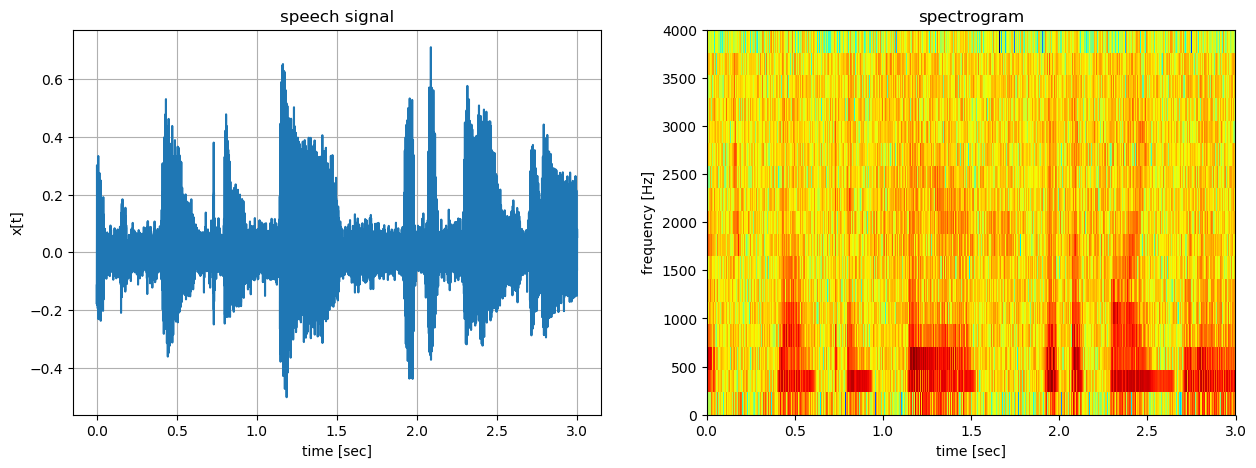

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 32, 0, fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Specify generative model

In [5]:
# create factor graph
fg = FactorGraph()

# placeholders
z_min = Array{Variable,1}(undef, 2*length(freq))
γ = Array{Variable,1}(undef, 2*length(freq))
θ = Array{Variable,1}(undef, 2*length(freq))
z = Array{Variable,1}(undef, 2*length(freq))

# specify observation noise
@RV v ~ GaussianMeanVariance(zeros(buffer_size), var_observation*Ic(buffer_size))

# specify previous hidden state (spectral component buffer)
for k = 1:2*length(freq)
    @RV [id=pad(:z_min,k)] z_min[k] ~ GaussianMeanVariance(placeholder(pad(:μ_z_min, k), dims = (AR_order,)),
                                        placeholder(pad(:Σ_z_min, k), dims = (AR_order, AR_order)))
    @RV [id=pad(:γ,k)] γ[k] ~ ForneyLab.Gamma(placeholder(pad(:a_γ,k)), placeholder(pad(:b_γ,k)))
    @RV [id=pad(:θ,k)] θ[k] ~ GaussianMeanVariance(placeholder(pad(:μ_θ,k), dims=(AR_order,)), placeholder(pad(:Σ_θ,k), dims=(AR_order, AR_order)))
    @RV [id=pad(:z,k)] z[k] ~ LAR.Autoregressive(θ[k], z_min[k], γ[k])
end

# specify Fourier matrix
Ceme1 = Array{Variable,1}(undef, 2*length(freq))
for k=1:2*length(freq)
    @RV Ceme1[k] 
    placeholder(Ceme1[k], pad(:Ceme1,k), dims = (buffer_size, AR_order))
end

# specify observations
@RV x = sum(Ceme1.*z)
@RV y = x + v

# create placeholder for observations
placeholder(y, :y, dims = (buffer_size,))

# draw factor graph
ForneyLab.draw(fg)
ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 227530932877728197 -->
 227530932877728197 
 
 placeholder_b_γ_11 
 
<!-- 16403649040506356362 -->
 16403649040506356362 
 
 + 
 addition_15 
 
<!-- 16324550107480091099 -->
 16324550107480091099 
 
 × 
 multiplication_16 
 
<!-- 16403649040506356362--16324550107480091099 -->
 16403649040506356362--16324550107480091099 
 
 variable_16 
 1 out 
 3 in2 
 
<!-- 5048003356419955281 -->
 5048003356419955281 
 
 + 
 addition_14 
 
<!-- 16403649040506356362--5048003356419955281 -->
 16403649040506356362--5048003356419955281 
 
 variable_44 
 1 out 
 2 in1 
 
<!-- 3716218599194525238 -->
 3716218599194525238 
 
 AR 
 autoregressive_19 
 
<!-- 4688623964538134732 -->
 4688623964538134732 
 
 𝒩 
 gaussianmeanvariance_39 
 
<!-- 3716218599194525238--4688623964538134732 -->
 3716218599194525238--4688623964538134732 
 
 θ_19 
 1 out 
 3 θ 
 
<!-- 7959254945083240448 -->
 7959254945083240448 
 
 Gam 
 gamma_19 
 
<!-- 3716218599194525238--7959254945083240448 -->
 3716218599194525238--7959254945083240448 
 
 γ_19 
 1 out 
 4 γ 
 
<!-- 4606156726946493448 -->
 4606156726946493448 
 
 𝒩 
 gaussianmeanvariance_38 
 
<!-- 3716218599194525238--4606156726946493448 -->
 3716218599194525238--4606156726946493448 
 
 z_min_19 
 1 out 
 2 x 
 
<!-- 3675563050784758035 -->
 3675563050784758035 
 
 AR 
 autoregressive_26 
 
<!-- 4426965923859966204 -->
 4426965923859966204 
 
 𝒩 
 gaussianmeanvariance_53 
 
<!-- 3675563050784758035--4426965923859966204 -->
 3675563050784758035--4426965923859966204 
 
 θ_26 
 1 out 
 3 θ 
 
<!-- 16287932115627109043 -->
 16287932115627109043 
 
 Gam 
 gamma_26 
 
<!-- 3675563050784758035--16287932115627109043 -->
 3675563050784758035--16287932115627109043 
 
 γ_26 
 1 out 
 4 γ 
 
<!-- 10986046613347719056 -->
 10986046613347719056 
 
 𝒩 
 gaussianmeanvariance_52 
 
<!-- 3675563050784758035--10986046613347719056 -->
 3675563050784758035--10986046613347719056 
 
 z_min_26 
 1 out 
 2 x 
 
<!-- 13757691752903079879 -->
 13757691752903079879 
 
 placeholder_μ_z_min_16 
 
<!-- 7886955374796489121 -->
 7886955374796489121 
 
 placeholder_b_γ_26 
 
<!-- 994018540608673343 -->
 994018540608673343 
 
 Gam 
 gamma_20 
 
<!-- 11457116668182197648 -->
 11457116668182197648 
 
 placeholder_b_γ_20 
 
<!-- 994018540608673343--11457116668182197648 -->
 994018540608673343--11457116668182197648 
 
 b_γ_20 
 1 out 
 3 b 
 
<!-- 7341685321135496066 -->
 7341685321135496066 
 
 placeholder_a_γ_20 
 
<!-- 994018540608673343--7341685321135496066 -->
 994018540608673343--7341685321135496066 
 
 a_γ_20 
 1 out 
 2 a 
 
<!-- 7927418440323529263 -->
 7927418440323529263 
 
 × 
 multiplication_12 
 
<!-- 6588845199436333714 -->
 6588845199436333714 
 
 AR 
 autoregressive_12 
 
<!-- 7927418440323529263--6588845199436333714 -->
 7927418440323529263--6588845199436333714 
 
 z_12 
 1 y 
 2 in1 
 
<!-- 12244446667808039729 -->
 12244446667808039729 
 
 placeholder_Ceme1_12 
 
<!-- 7927418440323529263--12244446667808039729 -->
 7927418440323529263--12244446667808039729 
 
 Ceme1_12 
 1 out 
 3 a 
 
<!-- 13892042601477802260 -->
 13892042601477802260 
 
 clamp_1 
 
<!-- 14755767298119696582 -->
 14755767298119696582 
 
 placeholder_a_γ_26 
 
<!-- 11323227346184973174 -->
 11323227346184973174 
 
 placeholder_Ceme1_11 
 
<!-- 16717054152575591935 -->
 16717054152575591935 
 
 placeholder_a_γ_12 
 
<!-- 14452314243469823694 -->
 14452314243469823694 
 
 placeholder_Σ_θ_18 
 
<!-- 10001466862646355606 -->
 10001466862646355606 
 
 placeholder_a_γ_07 
 
<!-- 15915963417

In [6]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(θ, z, z_min, γ, ids=[:θ :z :z_min :γ])
algo = compatibility_fix(variationalAlgorithm(q))
# algo_F = freeEnergyAlgorithm(q) # throws error because the variables z are all connected

# evaluate algorithm
eval(Meta.parse(algo))
;

In [7]:
println(algo)

begin

function stepγ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 60))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ_30]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ_30]))
messages[2] = ruleVariationalARIn3PPPN(marginals[:z_30], marginals[:z_min_30], marginals[:θ_30], nothing)
messages[3] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ_29]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ_29]))
messages[4] = ruleVariationalARIn3PPPN(marginals[:z_29], marginals[:z_min_29], marginals[:θ_29], nothing)
messages[5] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ_28]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ_28]))
messages[6] = ruleVariationalARIn3PPPN(marginals[:z_28], marginals[:z_min_28], marginals[:θ_28], nothing)
messa

## Perform inference

In [8]:
messages=Array{Message}(undef, 180)
data = Dict()
marginals = Dict()

# create placeholders for priors
μ_z_min = Array{Array{Float64,1},1}(undef, 2*length(freq))
Σ_z_min = Array{Array{Float64,2},1}(undef, 2*length(freq))
a_γ_min = Array{Float64,1}(undef, 2*length(freq))
b_γ_min = Array{Float64,1}(undef, 2*length(freq))
μ_θ_min = Array{Array{Float64,1},1}(undef, 2*length(freq))
Σ_θ_min = Array{Array{Float64,2},1}(undef, 2*length(freq))

# set priors 
for k = 1:2*length(freq)
    μ_z_min[k] = randn(AR_order)
    Σ_z_min[k] = 1e10*Ic(AR_order)
    a_γ_min[k] = 0.001
    b_γ_min[k] = 0.001
    μ_θ_min[k] = randn(AR_order)
    Σ_θ_min[k] = 1e0*Ic(AR_order)
end

# create marginals
for k = 1:2*length(freq)
    marginals[pad(:γ, k)] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=a_γ_min[k], b=b_γ_min[k])
    marginals[pad(:θ, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_θ_min[k], v=Σ_θ_min[k])
    marginals[pad(:z_min, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_z_min[k], v=Σ_z_min[k])
end

# initialize buffer
buf = BufferData(x_time, t, buffer_size)

# initialize placeholder for hidden states and observation
μ_x = Array{Float64,1}[]
Σ_x = Array{Float64,2}[]
μ_s = Array{Float64,1}[]
Σ_s = Array{Float64,2}[]

# create progress bar
p = Progress(len(buf, step_size), 1, "Observed ")

# loop through samples
for k = 1:len(buf, step_size)
        
    # update progress bar
    update!(p, k)
    
    # update data dictionary
    data[:y] = buf.buffer_s
    for f = 1:2*length(freq)
        data[pad(:Ceme1,f)] = calc_C(freq, buf.buffer_t)*em(2*length(freq), f)*(em(AR_order, 1)')
        data[pad(:a_γ, f)] = a_γ_min[f]
        data[pad(:b_γ, f)] = b_γ_min[f]
        data[pad(:μ_θ, f)] = μ_θ_min[f]
        data[pad(:Σ_θ, f)] = Σ_θ_min[f]
        data[pad(:μ_z_min, f)] = μ_z_min[f]
        data[pad(:Σ_z_min, f)] = Σ_z_min[f]
    end
    
    # run stepz! for prediction of x
    marginals = Base.invokelatest(stepz!, data, marginals, messages)  

    # get prediction of x
    push!(μ_x, ForneyLab.unsafeMean(messages[179].dist))
    push!(Σ_x, ForneyLab.unsafeCov(messages[179].dist))
    
    # infer parameters
    for it = 1:iterations
        
        # perform steps (z last to get prediction of x)
        marginals = Base.invokelatest(stepz!, data, marginals, messages)  
        marginals = Base.invokelatest(stepz_min!, data, marginals, messages)
        marginals = Base.invokelatest(stepγ!, data, marginals, messages)
        marginals = Base.invokelatest(stepθ!, data, marginals, messages)
        
    end
    
    # get spectral component values
    push!(μ_s, [ForneyLab.unsafeMean(marginals[pad(:z, k)])[1] for k=1:2*length(freq)])
    push!(Σ_s, diagm([ForneyLab.unsafeCov(marginals[pad(:z, k)])[1,1] for k=1:2*length(freq)]))
    
    # update hidden states
    for f = 1:2*length(freq)
        μ_z_min[f] = ForneyLab.unsafeMean(marginals[pad(:z,f)])
        Σ_z_min[f] = ForneyLab.unsafeCov(marginals[pad(:z,f)])
        a_γ_min[f] = marginals[pad(:γ,f)].params[:a]
        b_γ_min[f] = marginals[pad(:γ,f)].params[:b]
        μ_θ_min[f] = ForneyLab.unsafeMean(marginals[pad(:θ,f)])
        Σ_θ_min[f] = ForneyLab.unsafeCov(marginals[pad(:θ,f)])
    end
    
    # update buffer
    FLAG_data_remaining = step!(buf, step_size)
    
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:58


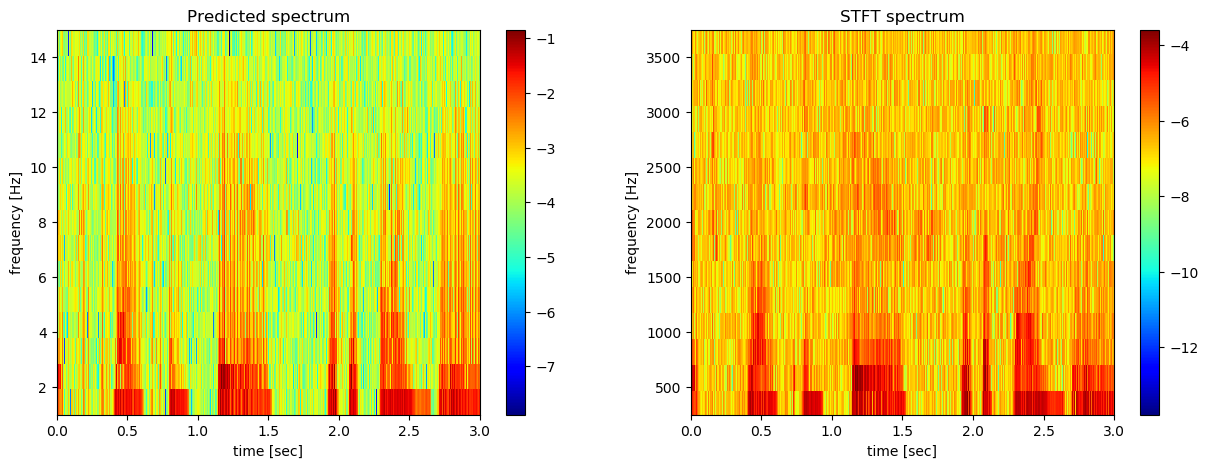

In [9]:
# convert μ_x to a 1d array
#μ_x_pred = expand((hcat(μ_x...),dims=1))

# convert s_x to a 2d array
if length(size(μ_s)) != 2
    μ_s = hcat(μ_s...)
end

# calculate magnitude spectrum
mag_μ_s = log10.((μ_s[1:length(freq),:].^2 + μ_s[length(freq)+1:end,:].^2))


# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
cmp = ax[1].imshow(mag_μ_s,
                   aspect="auto",
                   cmap="jet",
                   origin="lower",
                   extent=[minimum(t), maximum(t), 1, length(freq)])
fig.colorbar(cmp, ax=ax[1])

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 2*length(freq)+1, 0, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# change visuals
ax[1].set_xlim(minimum(t), maximum(t)), ax[2].set_ylim(minimum(freq), maximum(freq)), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency [Hz]"), ax[1].set_title("Predicted spectrum"), ax[2].set_title("STFT spectrum")
#cmp.set_clim(-3, -16)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQC+bOu90m43vtbknL3lVwW+rTffvGvZQ7zRDRc9LeioPZZWaz7LHn4+LFyaPsR5bj7MfEk+ERYrPm/OGTzr1QS9FbH1O4JSE76HETu+a9g5vq3qQL1oRGm9L2dhvQ6mWbvs3lE9CwVAvONymj0FhBa81Ztxva4pnb23MNm98kwMvr58tL28qga+i2KKvdBrab1JMb29ps7qPEHmBj6QgDo+6b44PjGniT70f4w+isSIPqZxMz4fF+O7tA3ou7FjkTxCpNm9X9FGvsK2O77ptZC9e06cvT6z4LwA/6y8GlN9PeXAKz0uIlA9GS+PvVYGe7zlB+68ccK3vdg75r2Wyy6+xeb2vUpa3r3RXfe9ZNaivb7Pkj3cPvw9mUxAPsHQbz5VKqo+q8eqPuyDXj4Mkz49brgEPUok/jx1a/a9G8Bdvh30bL6oig++DVHnvdAtvb0ii2y9DIy4PSjz3z1DvYU9e1qWvCrlST2KKAs8HUScPPE9vL0eCBa+82r1vVcX4L3IF8m9QOrGvaHOgTvhXto850QyPrR9ST5EzzU+2POJPo3Rfz597T0+QWzLPCY5ybyNbVO9VxblvfBtWb7YE0m+2dIFvvKYx73pq+m9+c5RvUvqEDwyOko9M1eEPZQyvzxP7Yk8WA1BvW71XDyOHhW+X0PIvWO3Yb0UncS8JtS0OyVZhD1GqhI+KCE7PvByZj43vYw+OzkePluGobtBuxE9NwLauyYPGL7wdC6+OYvHvX5pwr2FgT6+HFANvu+sE72dSeQ9qhMEPqMU2z3kgGQ8D7oEvThKeTwKuqY4EMFNvR9XSr3qRSG+ZkzJvS7Uz73DHbO9HGeNvUSm+Lz50xM9gjpAPUIZDD72euY9FjsvPjaRrT2Ak9Y9lrTcPRcmdj2Op0u8xqhsvdZKnrxgGbC91/T1vWTQk739ZJG9hEyqvW7pC76NaTU9V8vovCereLrUEZ69Iu1CvZQyiL2T4ZI7bZ8vvUBPhbu6HrU9l7LgPZa/Dz4aKko+gR9KPqzufj6BB4g9aYIUPGNhZbwQeca9hulyvksXcr4IvQO+k3zWvcJuLL7Gba+9LzN1Pc2swz2Q7649DEaiPa/zzz1vgdQ9AFHCPeXwwjuzZm+9svAEvQtneL1ZOYS9a3Alvny+1r2fWw+99EasvUYVib12b009Vm67PY8NijzfCZQ9d7l7O/DKgT36ejI9LNhKvKDzQj0F0dS8HiYMPX1svrza1ri8JGWbPKGv9DsBAeU8msYOvbC7vrzX2FC9OtpOvBhKObyPoEc6xoOMvBW4CTxp5ca85nbVOq/n1zyaZYE9VcNCPauToj1PlCk9t9ZrvUJJgj3/Bgg9IVUfPY+lKL2x1eU8w69kvW8zK711RMO8sqcmvdSG371p1Jq93BfhvH/Fvb16fi29GlSbvbiHizxOrCy9MdUvPVpSGj3pqjQ8tn18PNT107wgSgU9/khEPd6hozzCnHw9dXUBPV0CUDwgnLQ8VSTRvD/Zc71ay3K9upbAvFCgj73UYIG9xY0Gvt/dpr0NtwW9A++9vavcmb2iCaS8izuWPHeEwTt0QDK8+zxpPQlebzzoAKE9xHgrPIimsT0Iyeg90yzcPWF2JT6Wl8o9o17ePfIa5DwVudM8ncIzvf+h373pgyC+sfSjvResT755qgK+C9cavjnH0L3b9mC9nt/iOwPYXDsOgPA8+DWaPbhwgz2psbY9bVoNPftZyD2gHcg9drpDPodf8z1k3NY9ABQkPevAibxafYu8KITsvUE9kr28N/y9KduFvUTkbb3/Xye+a2I4vWw87TvUheo8SpHYOwJpBj0rINo9fvZsu/Fo4Tw98QU+4QSFPdDuDD3X7Ls7kk6EvXB5R725m6q9i3CovZKef70WZq+9Tg3lujpz67yP98Q8mBQHvC3zXzsnlJw7A57/vAFNFrw+0tq8SqMAO0YFKbznCDE8TF9SPYlfsrw0Mtg6aTZbvRNXv7xXfko84n30PPqthz1RnHw7z/mavARkqT1foxw9qjY/vA6F2DzQnls8VFWovEcoyjzYuho9Oli1vJNpy7yPbFC8FtUZPUUhNL3W6665kF0SvXwfvrwZpb+7gl6XvTeMyzzgLAw8KlAPPQ34Kj0Fyow7Mo2Eu8ICpT0jMjm9oREVPa9qFj2/DEw9jgBnPNtalDwLrJ88cgm5u6k+aDdFm409qebxPKsfjjxyrci5ItdRPCrPlTwE+cc7Uo18vYpno7vz8xO8m3kfvb6RBL16RdA8ndYoPElAPL1juyc97zyTPOBCMT3ehRU8pxOgPJwEPDwiZ468WxCdu8P6NrpHhqQ8lOHgvL7q6bwojhK9+hYBvWRXRD3qCIS83NcpPKLvyzx4++i7Zr8nPPlOMT2PjRO9xOOtPIYfBz3FkN47iepJvM0BDL12MbG8BbcIvdNCa70X0+S8ipEpPFGrWrxV7FW9m+N4vZnOVD2afiM9hizNvAy5aTsa4JC90B4IvM/dgD3QR1I7rwVOve9NpbzfhvG8iNiYvSo1ZL1Mo/28o/vxuwqaXL23OZw8OEq7vWlM97zxNa48yWpZvWU5GjyY6HS9eHnQPKSmd73blmu9n0umPD2y5ryHfJ+8lVBZO2/lhLzjbbM8BwaBvI/sHDzSPvK7ELcLuyVcRLySsey8ymv8vK+/2zvOaJY85jYqvJt3Mz0G1R69XFeqvJqyPTzhiJC7jTCYPHF5Hr1Xf4G8uzQru/U0hLvdYJg89WXOO9YZn7oZQK06WZMHvSavQj2sEY09NFqEOwpThbvF0Mc7MVC6vF53Ez0iXyK90t4Qu5lztDtKo408eVtPO76Rar0jIwg9m8l1vcnoubweHZ28R9q8vLmCMbsuaoi8Em6fvAZn9zujw/G7Ph84veanfj0sLrg8G/RdvbmhZb0Hp6+8fibauTPTyDpLvlE7GRw0OvywB73fqHY9phrOvFczhjw+0PM76JeAvLC4l7w18k28Okb+u9l/6TwBEFS7ndtKPLuz1TysIiy8csItu6krtLzZG4I8PridveLvc7tORlI9nMGyO00j+rw+IjS7DxioO/0E4rw1AmK8B/KEPDGb6rwHuTw9GmEcPfq+zLqpK/o83cqIurMcOj3gHEq82e2Gvb1Lm7sCStM8vjAnO2TMVL0Q/SY9ksLmPAGTLz2EDk88v1suPK3Sjrx4ycS7SYIxvSHXLD3KW1C8taVgvClkqzzWuX89O/9CPAONAL3z6za9cLngPIH107z6i089OlkbPWriJ73Umcc8UvsBvNgLsbrdiIi71GIuvGv3k7zhY5O8EPhLvKv0kTxNkT+8Y2jtPD8IrDuXBVO8jjA/PIwLorwtuv68qpvsO7gAyjvCr0+9t/mEvUP8B7yMNR89Oh11vZycG712HOe8sqWivE5nkbzqB1C82OI0PQalibzwq+S7Vm4LuArvkzyDmwi9BwVovcQkHr1wF6m9TnykugkEh7k26y29mx6JO6Hw8DzQtLC77ZnMPHxDFr3+KgG9U1oOPDWmObwmRr87rgbSPDfBiLyHtdu8vZqHvEbwbjwQHoU9MqMJPU+HvbuVwqo81wpOPCyYkjwPIkM9JJUavWz1O71Nigw8PU31PAJKa7yFdus8cfmXPCMoALwYHZ+7bbWLPLYCojw0+L09CATjPOXxEb0hGlw896s/vdMtF70saq+79nOPvPOB8LuXpXk9P5APPRxFILzBxim9oGGaPIUs/jsOPbU6dQpnvD+gPD2B+608VOAYvD/KEz2YfaE7ThPFuFYBAbzmgWU7pv31PIrk3TvQlou9JVWePaONLzxN+G88u/qgOxUir7zEieG8nrVePaFzVT1DjW28IbibvExYHzw6j1E8I5kyO4cnUb3lk

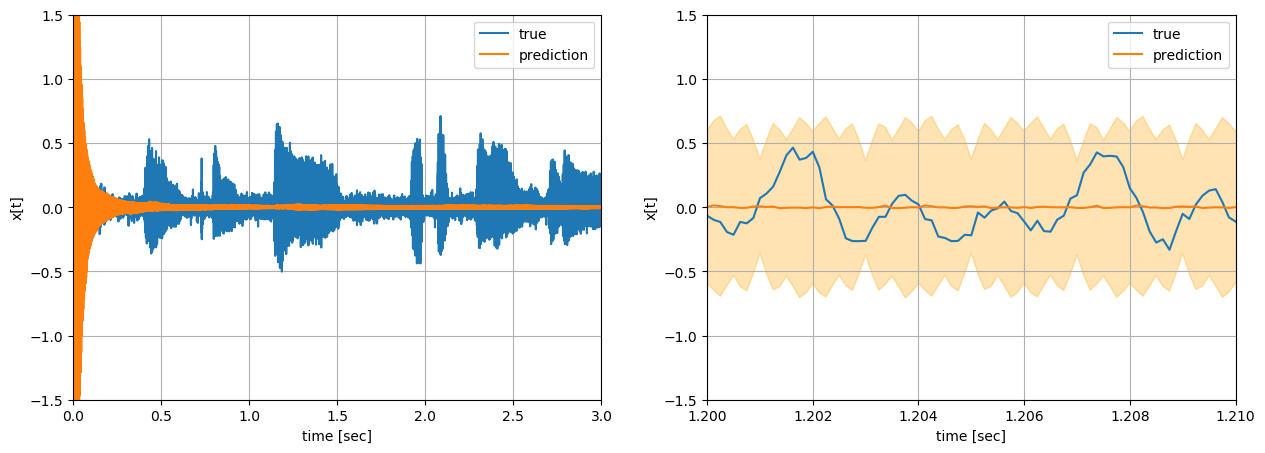

In [10]:
# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

μ_x_pred_select = simplify(reverse(hcat(μ_x...), dims=1))
var_x_pred_select = expand([reverse(diag(Σ_x[k])) for k =1:length(Σ_x)])

# plot actual, noisy and marginal of frequency component
ax[1].plot(t, x_time, label="true"), ax[1].plot(t[1:length(μ_x_pred_select)], μ_x_pred_select, label="prediction")#, ax[1].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")
ax[2].plot(t, x_time, label="true"), ax[2].plot(t[1:length(μ_x_pred_select)], μ_x_pred_select, label="prediction")#, ax[2].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")
ax[2].fill_between(t[1:length(μ_x_pred_select)], μ_x_pred_select .- sqrt.(var_x_pred_select), μ_x_pred_select .+ sqrt.(var_x_pred_select), alpha=0.3, color="orange")

# change vizualization
ax[1].grid(), ax[1].set_xlim(0,3), ax[1].set_ylim(-1.5, 1.5), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("x[t]"), ax[1].legend()
ax[2].grid(), ax[2].set_xlim(1.2,1.21), ax[2].set_ylim(-1.5, 1.5), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("x[t]"), ax[2].legend()

# create audioplayers
audioplayers(x_time, x_time_clean, μ_x_pred_select, fs=fs_desired)
;

## Performance metrics

In [14]:
MSE = 1/length(μ_x_pred_select) * sum(abs.(μ_x_pred_select - x_time[1:length(μ_x_pred_select)]).^2)

0.10516263969924414

In [15]:
MAE = 1/length(μ_x_pred_select) * sum(abs.(μ_x_pred_select - x_time[1:length(μ_x_pred_select)]))

0.1013525368025279

In [16]:
using Distributions;
logBME = Float64[]
# initialize buffer
buf = BufferData(x_time, t, buffer_size)
for k = 1:length(μ_x)
    try 
        push!(logBME, sum([1/buffer_size*logpdf(Distributions.Normal(μ_x[k][ki], sqrt(Σ_x[k][ki,ki])), buf.buffer_s[ki]) for ki=1:buffer_size]))
    catch
    end
    step!(buf, step_size)
end
print("nr: "* string(length(logBME))* "       mean:"* string(mean(logBME)))

nr: 799       mean:-0.4613710192116085